##  Predictive Analytics: Choosing the model with highest ROI for Term Deposit Campaigns

* In this analysis I am trying to fit a predictive model to predict whether a bank customer will subscribe to a term deposit and then try to report the results in a clear and concise manner using the package 'modelplotpy'.
* We will also look at how the predictive model is doing locally using the package 'lime'.
* The dataset has various kinds of features associated with 1 row ( = 1 customer). Lets explore.




* Importing required libraries

In [1]:
# Importing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
import seaborn as sns
import modelplotpy as mp
import numpy as np
import warnings
warnings.filterwarnings("ignore")

C:\Users\cgokh\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
data = pd.read_csv("../bank-additional/bank-additional-full.csv", sep=";")
data.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon ...         1    999         0  nonexistent          1.1   
1   may         mon ...         1    999         0  nonexistent          1.1   
2   may         mon ...         1    999         0  nonexistent          1.1   
3   may         mon ...         1    999         0  nonexistent          1.1   
4   may         mon ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

* We are using the UCI [Bank Marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing)
* As we can see above, each row represents a customer of the bank with details related to the customer in subsequent columns.
* We have demographic details, product (bank products) related details, marketing campaign details and some economic factors.
* The target variable for this study is whether the customer subscribed to term deposit or not?
* 'duration' feature is marked as a potential leak by the data creators so we will not use this feature in the analysis. With 'duration' any model performs very well, without it it will be interesting to see how results shape up. That is good for us because in real life we seldom find 'wizard models' (models that perform exceptionally well)

</br>

#### Data preparation and fitting predictive models using sklearn

In [5]:
# Firstly, lets change the name of the target column as well as the 'yes' level to a more meaningful name
data['y'].replace({'yes': 'term_deposit'}, inplace=True)

data.drop(['month', 'day_of_week', 'duration'], axis=1, inplace=True)

y = data['y']
#encode_y = LabelEncoder()
#y_encoded = encode_y.fit_transform(y)

data.drop('y', axis=1, inplace=True)

data = pd.get_dummies(data)

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.1, random_state=123)

rf_classifier = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=5, min_samples_split=0.1,
                                      max_features='auto')
rf_classifier.fit(X_train, y_train)

gbm_classifier = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, subsample=0.85, max_depth=10)
gbm_classifier.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=0.85, verbose=0,
              warm_start=False)

#### Checking the model performance using traditional metrics

In [6]:
gbm_preds = gbm_classifier.predict(X_test)
rf_preds = rf_classifier.predict(X_test)

#### Random Forest Confusion Matrix (Threshold= 0.5)

In [7]:
confusion_matrix(y_test, rf_preds)

array([[3666,    5],
       [ 439,    9]], dtype=int64)

* So confusion matrix for Random Forest is interesting.
* At 0.5 threshold which is the default threshold for rf.predict() method, we have just 17 observations predicted to be subscribing for TERM DEPOSIT.
* Lets look at the distribution of the probabilities

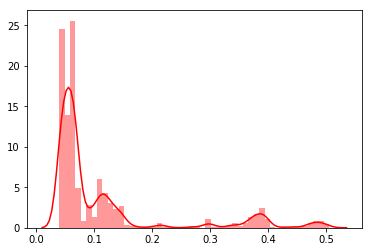

In [8]:
rf_probs = rf_classifier.predict_proba(X_test)
rf_probs = np.array([i[1] for i in rf_probs])
sns.distplot(rf_probs, kde=True, color='r')

* We can see that there are hardly any probabilities predicted beyond 0.5
* This is why 0.5 threshold is yielding only 17 predicted 'term_deposit' classes
* What to make of this model? Is it good? Is it bad?
* We will get to that later.
* First let us compare this to GBM model which we have fit

In [9]:
confusion_matrix(y_test, gbm_preds)

array([[3516,  155],
       [ 309,  139]], dtype=int64)

* The confusion matrix from gbm predictions shows a completely opposite picture.
* Lets check the distribution of probabilities.

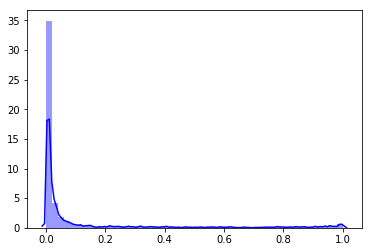

In [10]:
gbm_probs = gbm_classifier.predict_proba(X_test)
gbm_probs = np.array([i[1] for i in gbm_probs])
sns.distplot(gbm_probs, kde=True, color='b')

* We can see here that GBM model predicts more observations having probabilities > 0.5 and so we have larger numbers in that right column. By the way, the Confusion Matrix has Predictions on horizontal axis and Actual values on vertical axis.
* Again, we have confusion matrices of both models. We can easily get precision and recall scores too but how to know which model is better?

</br>

* Lets try to use an additional tool to judge which model is better.
* Package **modelplotpy** provides us with 4 graphs. 1 of them is 'Cummulative Gains'.
* Lets get the graph for RF model. I will mention what the graph shows below it.

Default scope value no_comparison selected, single evaluation line will be plotted.
The label with smallest class is term_deposit
Target class term_deposit, dataset test data and model random forest.
When we select 20% with the highest probability according to model random forest, this selection holds 59% of all term_deposit cases in dataset test data.
The cumulative gains plot is saved in C:\Github\JupyterNotebooks\Notebooks/Cumulative gains plot.png


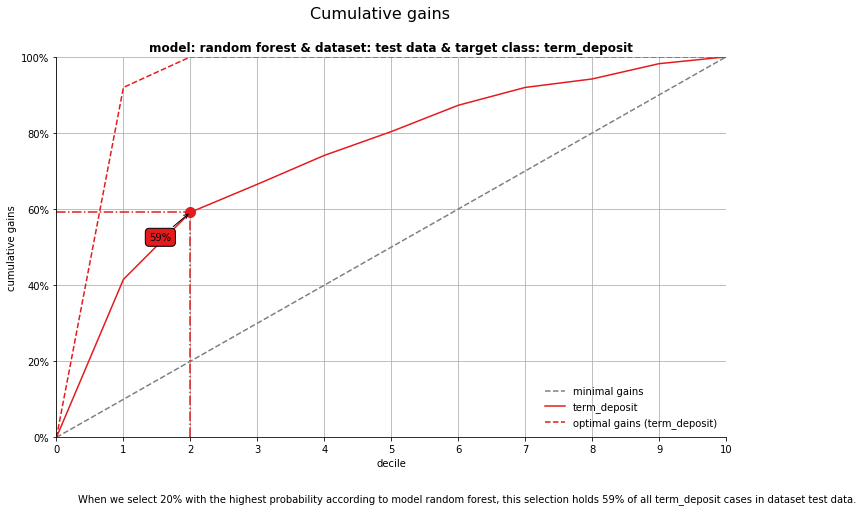

<Figure size 432x288 with 0 Axes>

In [11]:
obj = mp.modelplotpy(feature_data = [X_train, X_test]
                     , label_data = [y_train, y_test]
                     , dataset_labels = ['train data', 'test data']
                     , models = [rf_classifier, gbm_classifier]
                     , model_labels = ['random forest', 'gradient boosting']
                     )

# transform data generated with prepare_scores_and_deciles into aggregated data for chosen plotting scope 
ps = obj.plotting_scope(select_model_label = ['random forest'], select_dataset_label = ['test data'])

mp.plot_cumgains(ps, highlight_decile=2)

* The above graph has inverted deciles of predicted probability distribution on X-axis
* So 1 is the 9th decile, 2 is the 8th decible and so on.
* Y-axis has % of actual positive classes we retain if we use the particular X-axis decile as our threshold.
* So for example, if we use Decile 2 (which is actually 8th Decile) as our threshold for classifying term deposits, we will get 58% of the total actual term deposit subscribing customers in the test set.
* So in our case we have 448 total Positive classes in our test set. Out of that, if we use 8th decile of the current Predicted Probability distribution as our threshold, we will correctly TARGET 265 of those 448 customers.
* One thing this graph does not tell us is how many False Positives will we have in the Top 20% of those probabilities.
* Let us find that out ourselves using the following code.

In [12]:
# Extracting indices of Probs. over 80 percentile or 8th Decilbe (Top 20% probabilities)
rf_probs_top20percent_indices = np.where(rf_probs > np.quantile(rf_probs, 0.8))

# Using those indices to get the true labels of those probs.
rf_probs_top20percent_y_test = np.array(y_test)[rf_probs_top20percent_indices]

# Separating top 20% probs in a separate array
rf_probs_top20percent_probs = rf_probs[rf_probs_top20percent_indices]

# creating all positive predictions for top 20% probabilities
rf_probs_top20percent_preds = np.where(rf_probs_top20percent_probs > 0, 'term_deposit', 'no')

confusion_matrix(rf_probs_top20percent_y_test, rf_probs_top20percent_preds)

array([[  0, 559],
       [  0, 265]], dtype=int64)

* We can see we got 265 True Positives (~59% of 448 total positive cases retained).
* And as a result of using top 20% we will end up campaigning on 559 customers wrongly.
* Suppose our earnings per positive customer is 25 USD and cost per wrong customer is 5 USD (I am just making up the numbers here), then our Net profit if we use this model will be (265 x 25)-(559 x 5) = 6625 - 2795 = 3830 USD.
* Let us do this same exercise for GBM now and see how much net profit that model will have?

Default scope value no_comparison selected, single evaluation line will be plotted.
The label with smallest class is term_deposit
Target class term_deposit, dataset test data and model gradient boosting.
When we select 30% with the highest probability according to model gradient boosting, this selection holds 62% of all term_deposit cases in dataset test data.
The cumulative gains plot is saved in C:\Github\JupyterNotebooks\Notebooks/Cumulative gains plot.png


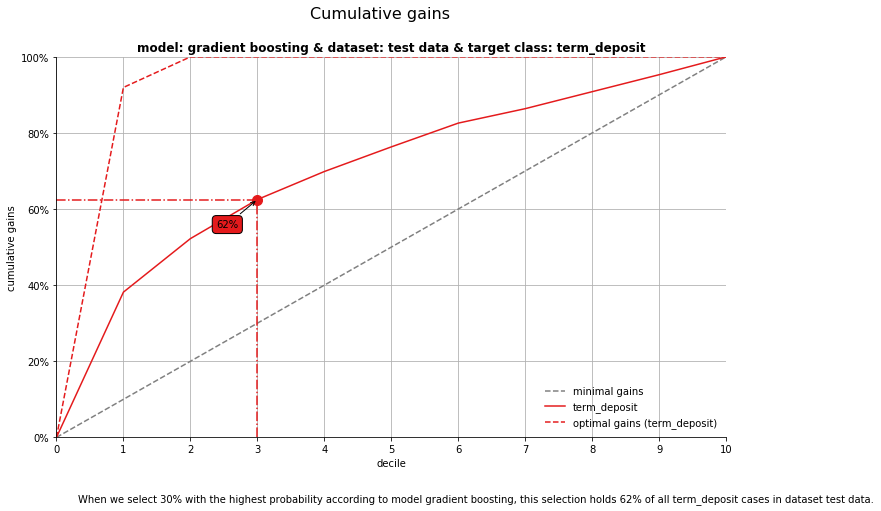

<Figure size 432x288 with 0 Axes>

In [13]:
# transform data generated with prepare_scores_and_deciles into aggregated data for chosen plotting scope 
ps_gbm = obj.plotting_scope(select_model_label = ['gradient boosting'], select_dataset_label = ['test data'])

mp.plot_cumgains(ps_gbm, highlight_decile=3)

* 'Cummulative gains' plot for GBM model shows us that top 30% probs. recover 60% positive cases from the test set.
* Lets calculate the net profit.

In [14]:
# Extracting indices of Probs. over 80 percentile or 8th Decilbe (Top 20% probabilities)
gbm_probs_top20percent_indices = np.where(gbm_probs > np.quantile(gbm_probs, 0.7))

# Using those indices to get the true labels of those probs.
gbm_probs_top20percent_y_test = np.array(y_test)[gbm_probs_top20percent_indices]

# Separating top 20% probs in a separate array
gbm_probs_top20percent_probs = gbm_probs[gbm_probs_top20percent_indices]

# creating all positive predictions for top 20% probabilities
gbm_probs_top20percent_preds = np.where(gbm_probs_top20percent_probs > 0, 'term_deposit', 'no')

confusion_matrix(gbm_probs_top20percent_y_test, gbm_probs_top20percent_preds)

array([[  0, 956],
       [  0, 280]], dtype=int64)

* So for GBM the net profit is (273 x 25) - (963 x 5) = 2010 USD.
* So we can see that if we use GBM model we will have a reduction of 3830 - 2010 = 1820 USD in profits.
* Hence, we should use Random Forest model for our marketing efforts.


## Will an optimized f-score threshold give us a better ROI?

* Right now we have used deciles to decide the threshold and then calculated ROI.
* Can it happen that if we choose some other threshold, we may get better ROI?
* Lets optimize the threshold such that we get the best f-score and calculate ROI using that.
* So that we can compare that and this.

Text(0,0.5,'%')

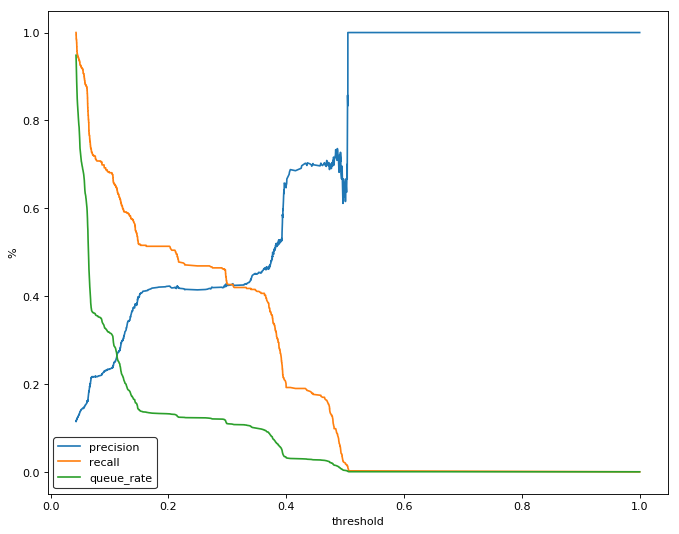

In [38]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

%matplotlib inline

lbl_enc = LabelEncoder()
y_test_encoded = lbl_enc.fit_transform(y_test)

precision, recall, thresholds = precision_recall_curve(y_test_encoded, rf_probs, pos_label=1)

fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
thresholds = np.append(thresholds, 1)
queue_rate = [] 
for threshold in thresholds:
    queue_rate.append((rf_probs >= threshold).mean())
plt.plot(thresholds, precision, color=sns.color_palette()[0])
plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2])
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')

* Above code is the [courtesy of the following post](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415/)
* This plot shows us 3 things
    1. Queue Rate - Out of all the score test observations, % of users selected to taken action upon (marketing in our case. Can be churn etc.. in other cases)
    2. Precision - Of all the customers to whom we do end up marketing, % of customers who will actually but term deposit.
    3. Recall - Of all the customers who would have bought term deposit, % of customers to whom we end up marketing.
* Second and third ones we already know.
* So for our Random Forest model, the best threshold for an optimum precision and recall seems to be around 0.3
* Lets see how our ROI will look like if we select 0.3

In [52]:
# Extracting indices of Probs. over 80 percentile or 8th Decilbe (Top 20% probabilities)
rf_probs_top20percent_indices = np.where(rf_probs > 0.3)

# Using those indices to get the true labels of those probs.
rf_probs_top20percent_y_test = np.array(y_test)[rf_probs_top20percent_indices]

# Separating top 20% probs in a separate array
rf_probs_top20percent_probs = rf_probs[rf_probs_top20percent_indices]

# creating all positive predictions for top 20% probabilities
rf_probs_top20percent_preds = np.where(rf_probs_top20percent_probs > 0, 'term_deposit', 'no')

confusion_matrix(rf_probs_top20percent_y_test, rf_probs_top20percent_preds)

array([[  0, 259],
       [  0, 191]], dtype=int64)

* Profit = Earnings - Costs = 4775 - 1295 = USD 3480
* This is lower than ~3800 if we select the threshold by Best deciles method.
* One thing to also note here is that the Avg. cost to take marketing action (USD 5 taken by us) and Avg. earning per marketed customer (USD 25 taken by us) hugely alter the way the PROFIT figure shapes up.
* So it may happen that if these numbers are different in real life, we might have to make decisions accordingly.
* But as of now, according to whatever figures we have taken, Method 1 has proved to be better.

### Examine cases for different values of costs and gains

#### Case 1: Low costs and high gains

* If we have very low costs then we don't mind having more False Positives.
* In cases like these, we don't mind low precision so that we can choose high recall values.
* Let assume costs=USD 2 per failed customer and gains=USD 25 per succeeded customer.
* So lets see what happens when we take a high recall value and low precision value.
* Looking at the graph, lets select threshold of 0.05 corresponding to recall ~ 90%

In [56]:
# Extracting indices of Probs. over 80 percentile or 8th Decilbe (Top 20% probabilities)
rf_probs_top20percent_indices = np.where(rf_probs > 0.05)

# Using those indices to get the true labels of those probs.
rf_probs_top20percent_y_test = np.array(y_test)[rf_probs_top20percent_indices]

# Separating top 20% probs in a separate array
rf_probs_top20percent_probs = rf_probs[rf_probs_top20percent_indices]

# creating all positive predictions for top 20% probabilities
rf_probs_top20percent_preds = np.where(rf_probs_top20percent_probs > 0, 'term_deposit', 'no')

confusion_matrix(rf_probs_top20percent_y_test, rf_probs_top20percent_preds)

array([[   0, 2613],
       [   0,  415]], dtype=int64)

* Total costs = 5 x 999 = 5,226
* Total gains = 415 x 25 = 10,375
* Profit = 10,375 - 5,226 = 5149


* Profit increased. So we can see that looking at our Avg. gains and costs, we can take a decision on precision and recall.

#### Case 2: High costs and Low gains

* In some cases we might have a high cost of taking an action.
* In cases like these, we want to minimize the False Positives hence we want a high precision.
* Let assume costs=USD 50 per failed customer and gains=USD 25 per succeeded customer.
* So lets see what happens when we take a high precision value and low recall value.
* Looking at the graph, lets select threshold of 0.475 corresponding to recall ~ 80%

In [60]:
# Extracting indices of Probs. over 80 percentile or 8th Decilbe (Top 20% probabilities)
rf_probs_top20percent_indices = np.where(rf_probs > 0.475)

# Using those indices to get the true labels of those probs.
rf_probs_top20percent_y_test = np.array(y_test)[rf_probs_top20percent_indices]

# Separating top 20% probs in a separate array
rf_probs_top20percent_probs = rf_probs[rf_probs_top20percent_indices]

# creating all positive predictions for top 20% probabilities
rf_probs_top20percent_preds = np.where(rf_probs_top20percent_probs > 0, 'term_deposit', 'no')

confusion_matrix(rf_probs_top20percent_y_test, rf_probs_top20percent_preds)

array([[ 0, 26],
       [ 0, 59]], dtype=int64)

* Profit = (59 x 25) - (26 x 50) = 1475 - 1300 = 175
* This gives us very less profit.
* Usually in real life this will never be the case because products and successes earn big sums.

### Doing the same thing with gradient boosting result probabilities


* Let us try GBM predicted probabilities.
* For that we will first need a precision recall curve for GBM.

Text(0,0.5,'%')

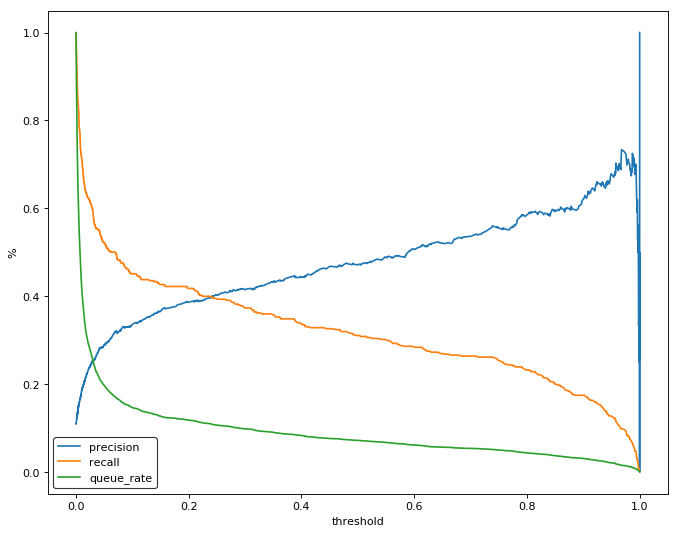

In [61]:
lbl_enc = LabelEncoder()
y_test_encoded = lbl_enc.fit_transform(y_test)

precision, recall, thresholds = precision_recall_curve(y_test_encoded, gbm_probs, pos_label=1)

fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
thresholds = np.append(thresholds, 1)
queue_rate = [] 
for threshold in thresholds:
    queue_rate.append((gbm_probs >= threshold).mean())
plt.plot(thresholds, precision, color=sns.color_palette()[0])
plt.plot(thresholds, recall, color=sns.color_palette()[1]) 
plt.plot(thresholds, queue_rate, color=sns.color_palette()[2])
leg = plt.legend(('precision', 'recall', 'queue_rate'), frameon=True)
leg.get_frame().set_edgecolor('k')
plt.xlabel('threshold')
plt.ylabel('%')

* Best precision recall combination is around 0.25

In [66]:
# Extracting indices of Probs. over 80 percentile or 8th Decilbe (Top 20% probabilities)
gbm_probs_top20percent_indices = np.where(gbm_probs > 0.23)

# Using those indices to get the true labels of those probs.
gbm_probs_top20percent_y_test = np.array(y_test)[gbm_probs_top20percent_indices]

# Separating top 20% probs in a separate array
gbm_probs_top20percent_probs = gbm_probs[gbm_probs_top20percent_indices]

# creating all positive predictions for top 20% probabilities
gbm_probs_top20percent_preds = np.where(gbm_probs_top20percent_probs > 0, 'term_deposit', 'no')

confusion_matrix(gbm_probs_top20percent_y_test, gbm_probs_top20percent_preds)

array([[  0, 275],
       [  0, 179]], dtype=int64)

* Profit = 3100.
* This is better than the previous best deciles threshold we used for the GBM model

## Future Efforts

**1. We validated our Profit results only on one test set, but it may happen that the results might change on a different test 
set. So can we create a system which will give us robust profit values? (Cross-validated profit values)**

**2. Use LIME to Trust the predictive model which we will decide to implement in production.**

**3. Use LIME to improve the model results if possible by looking at feature to response relationships locally.**